Стан Илья 520

# Применение моделей с гетероскедостичностью $ARCH/GARCH$

1. Выбрать волотильные российские акции (2 акции из разных секторов экономики)
2. Выбрать волотильную криптовалюту

К выбранным активам попытаться подобрать модель с условной гетероскедостичностью, попробовать модели с различными видами остатков

Для проверяемой модели выписать математическую формулу (какая зависимость подгоняется)

GARCH моделей достаточно много, попробуйте хотя бы три модели.

Предварительный анализ временного ряда необходимо провести, возможно, потребуются какие-то преобразования.

Для выбранной модели/моделей построить прогноз актива на 5/10/20 торговых сессий.

**Активы у всех должны быть разными (надо согласовать между собой самостоятельно)**

**Модель ARCH порядка 𝑝 имеет следующий вид:**

$$\sigma_t^2 = w_t \sqrt{ a_0 + \sum_{i=1}^p a_i \epsilon_{t-i}^2}$$

**Модель GARCH порядков p, q имеет следующий вид:**

$$\epsilon_t = \sigma_t w_t$$

где $w_t$ – белый шум с нулевым средним и единичной дисперсией, а часть $\sigma_t^2$ имеет вид:

$$\sigma_t^2 = a_0 + \sum_{i=1}^q a_i \sigma_{t-i}^2 + \sum_{j=1}^p b_j \epsilon_{t-j}^2$$

где $a_i$ и $b_j$ – это параметры модели. Процесс $\epsilon_t$ является **GARCH(p,q)**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
a = np.array([90, 91, 85])
b = a[1:] / a[:-1] - 1  # pct_change()

last_price = a[0]
for i in b:
    last_price = (i + 1) * last_price
    print(last_price)

91.0
85.0


# Выгрузка данных

Преобразование в числа + (следующее / предыдущее - 1) + разворот при необходимости

(Модели надо применять к стационарным процессам)

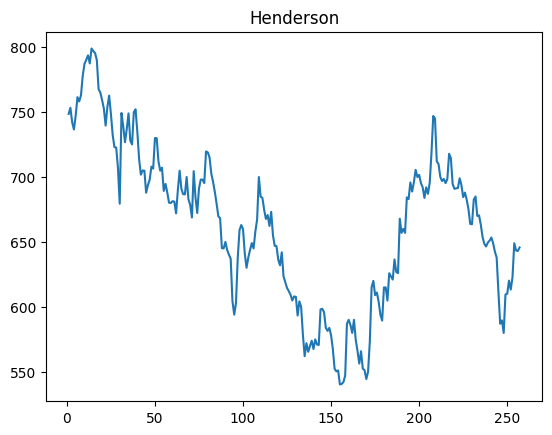

DF p-value = 0.2800796538938538


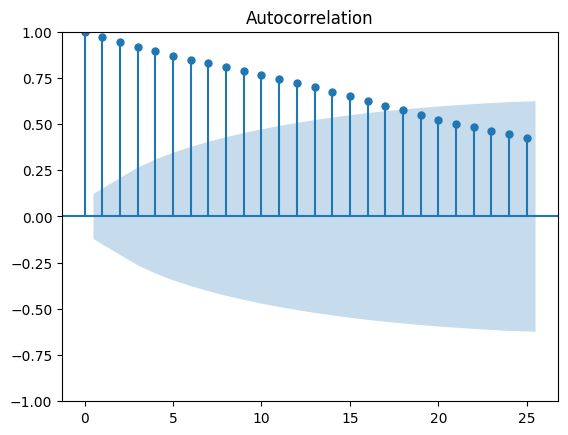

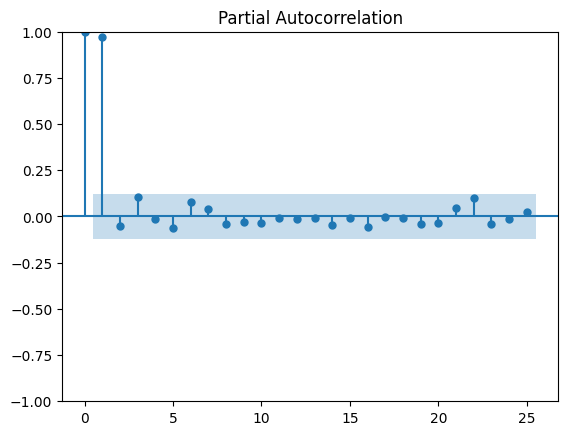

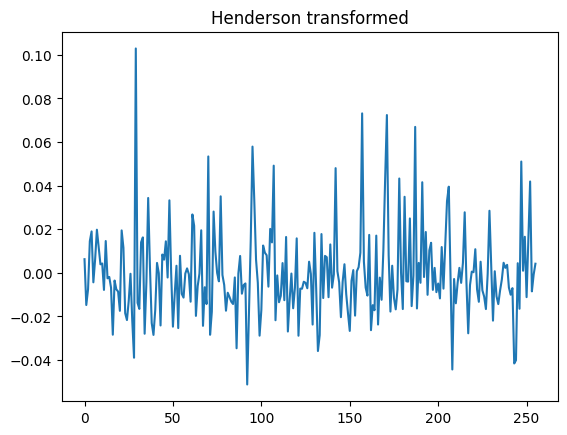

DF p-value = 1.5769365709638388e-22


In [3]:
hnfg = pd.read_csv("HNFG.csv", sep=";").iloc[1:-1]
hnfg = hnfg.High.apply(lambda x: float(x.replace(",", ".")))

plt.plot(hnfg)
plt.title("Henderson")
plt.show()
print(f'DF p-value = {adfuller(hnfg)[1]}')
plot_acf(hnfg)
plt.show()
plot_pacf(hnfg)
plt.show()

hnfg_ = hnfg.pct_change()[1:].to_numpy()
plt.plot(hnfg_)
plt.title("Henderson transformed")
plt.show()
print(f'DF p-value = {adfuller(hnfg_)[1]}')

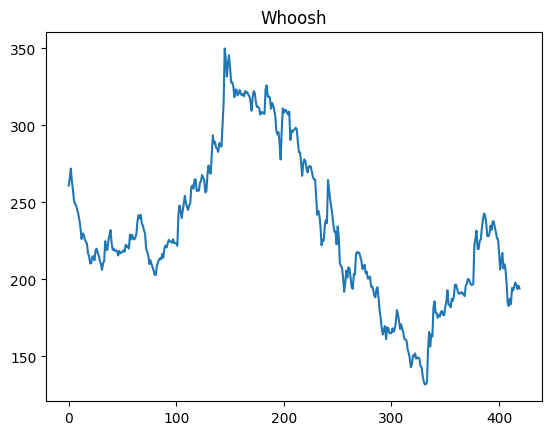

DF p-value = 0.6365598077166034


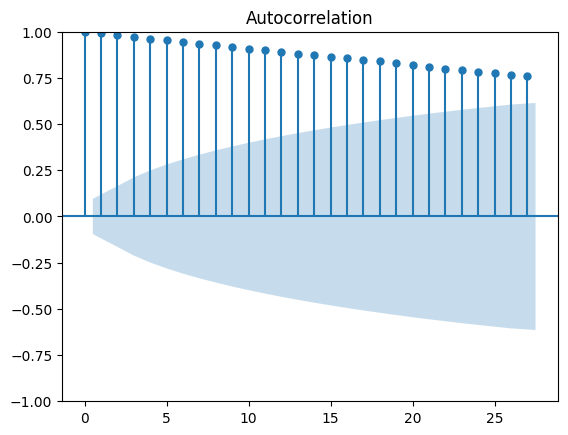

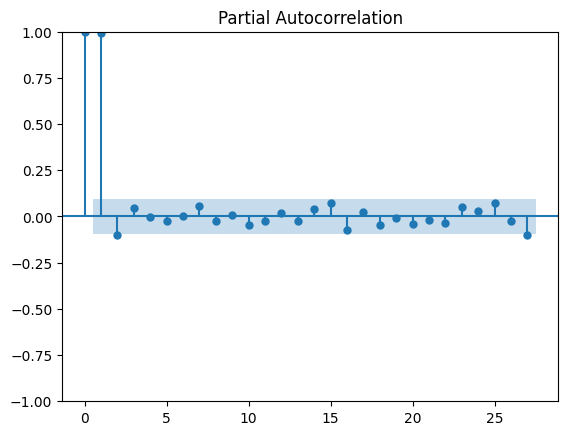

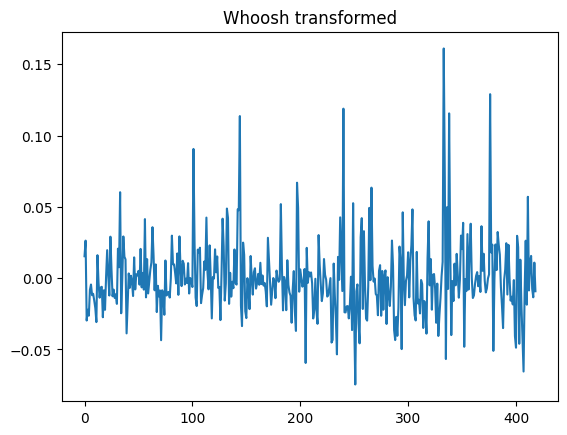

DF p-value = 2.296855067717318e-30


In [4]:
wush = pd.read_csv("WUSH.csv")
wush = wush["Макс."].apply(lambda x: float(x.replace(",", ".")))[::-1].reset_index(drop=True)

plt.plot(wush)
plt.title("Whoosh")
plt.show()
print(f'DF p-value = {adfuller(wush)[1]}')
plot_acf(wush)
plt.show()
plot_pacf(wush)
plt.show()

wush_ = wush.pct_change()[1:].to_numpy()
plt.plot(wush_)
plt.title("Whoosh transformed")
plt.show()
print(f'DF p-value = {adfuller(wush_)[1]}')

/Users/ilia.stan/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


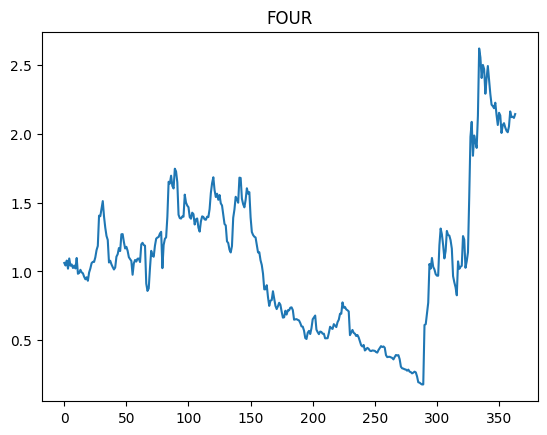

DF p-value = 0.7322815803951612


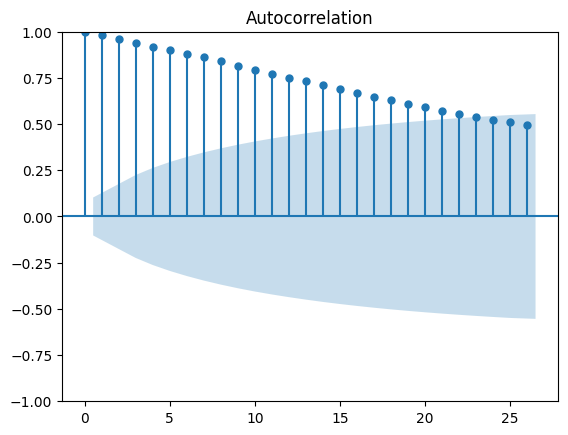

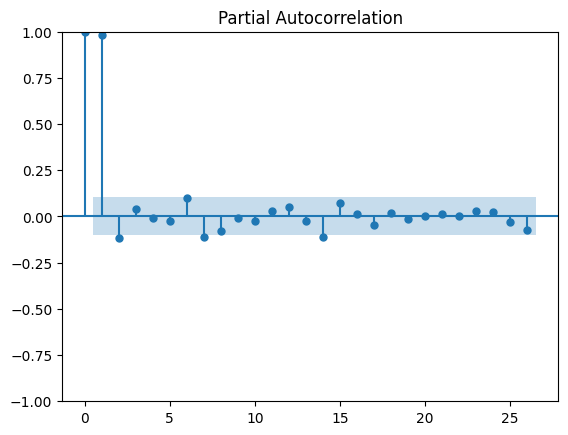

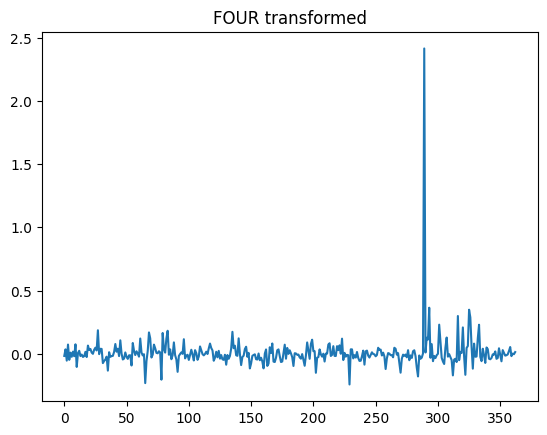

DF p-value = 2.4755888902578184e-30


In [5]:
sol = pd.read_excel("FOUR.xlsx")
sol = sol["priceHigh"][::-1].reset_index(drop=True)

plt.plot(sol)
plt.title("FOUR")
plt.show()
print(f'DF p-value = {adfuller(sol)[1]}')
plot_acf(sol)
plt.show()
plot_pacf(sol)
plt.show()

sol_ = sol.pct_change()[1:].to_numpy()
plt.plot(sol_)
plt.title("FOUR transformed")
plt.show()
print(f'DF p-value = {adfuller(sol_)[1]}')

# Прогнозирование разными моделями GARCH

In [6]:
ps = (1, 2)
qs = (0, 1)
os = (0, 1, 2)
origs = {"Henderson": hnfg, "Whoosh": wush, "FOUR": sol}
series = {"Henderson": hnfg_, "Whoosh": wush_, "FOUR": sol_}

metrics = {"Henderson": [], "Whoosh": [], "FOUR": []}
for p in ps:
    for q in qs:
        for o in os:
            for name, s in series.items():
                model = arch_model(s, vol = 'GARCH', p = p, q = q, o=o, rescale = False, )
                results = model.fit(disp='off',show_warning = False)
                squared_residuals = results.resid**2
                arch_test = het_arch(squared_residuals)
                metrics[name].append((p, o, q, results.bic, arch_test[1]))
metrics

{'Henderson': [(1, 0, 0, -1242.1389376558036, 0.9999924842595301),
  (1, 1, 0, -1219.33365510931, 0.9999922370637432),
  (1, 2, 0, -1213.2081421995165, 0.9999926463896561),
  (1, 0, 1, -1245.8233842267568, 0.9999926154250645),
  (1, 1, 1, -1243.937522400827, 0.9999923548884451),
  (1, 2, 1, -1238.392376828992, 0.9999923569195333),
  (2, 0, 0, -1245.8233822953573, 0.9999926158699857),
  (2, 1, 0, -1210.1153491666307, 0.9999932622509395),
  (2, 2, 0, -1204.3446415706997, 0.9999934344712816),
  (2, 0, 1, -1238.426696730128, 0.9999926967196491),
  (2, 1, 1, -1238.392342134656, 0.9999923552647793),
  (2, 2, 1, -1232.847153510052, 0.9999923550119637)],
 'Whoosh': [(1, 0, 0, -1772.6280455282777, 0.1503478718260082),
  (1, 1, 0, -1772.9393993429271, 0.15145206537208988),
  (1, 2, 0, -1764.1458290501698, 0.1503765260859007),
  (1, 0, 1, -1839.5293785433782, 0.1513576466829242),
  (1, 1, 1, -1834.6691696596274, 0.15277642703156982),
  (1, 2, 1, -1833.718518437419, 0.15162239317720666),
  (2, 0, 

Все модели хорошие с точки зрения гетероскедастичности.

Лучшие модели:

In [7]:
parameters = {}
for name, e in metrics.items():
    best = min(e, key=lambda x: x[3])
    parameters[name] = {"p": best[0], "o": best[1], "q": best[2]}
parameters

{'Henderson': {'p': 1, 'o': 0, 'q': 1},
 'Whoosh': {'p': 1, 'o': 0, 'q': 1},
 'FOUR': {'p': 1, 'o': 0, 'q': 1}}

# Прогнозирование

Учтём, что модели обучены на преобразованных сериях.

Henderson


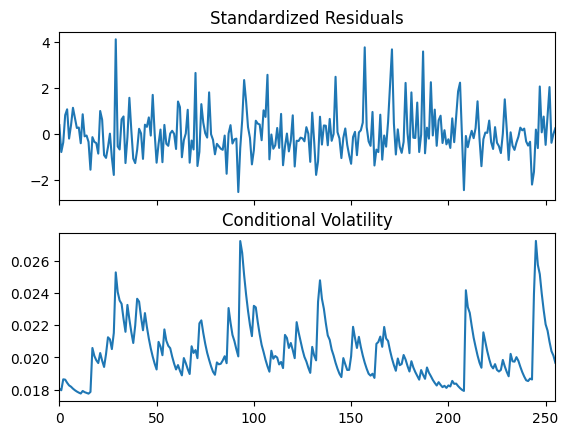

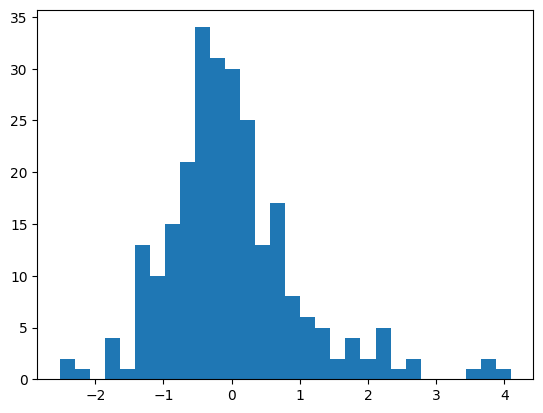

Whoosh


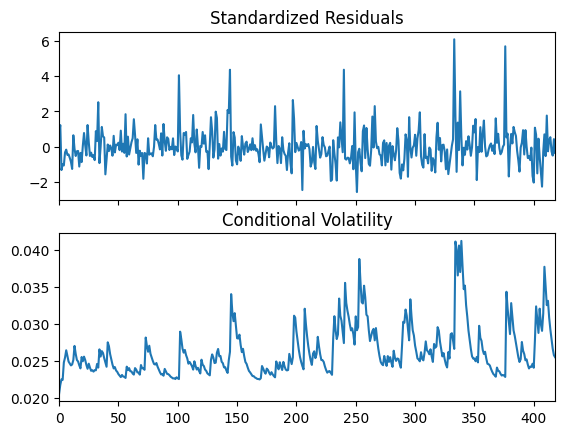

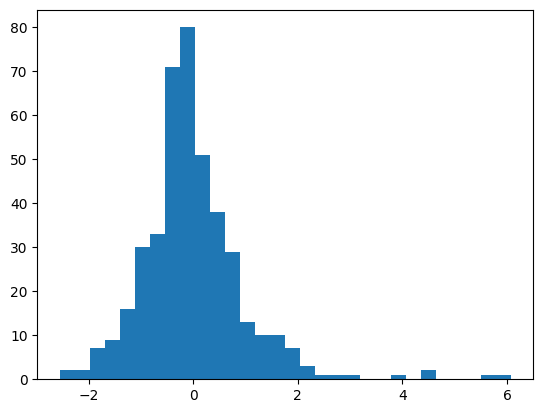

FOUR


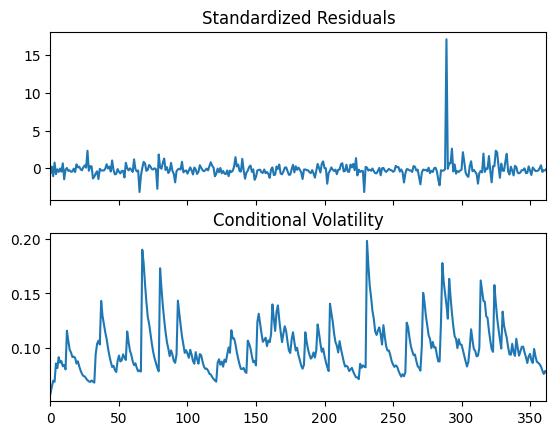

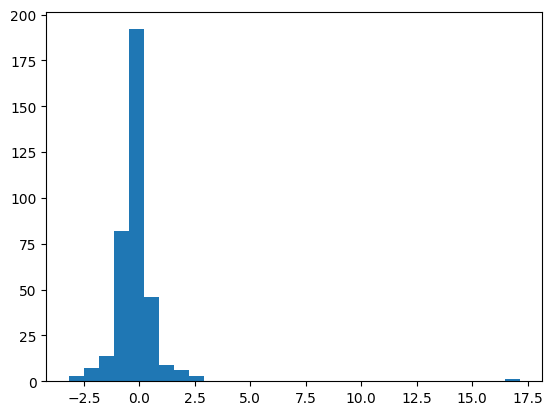

In [8]:
models = {}

for name, params in parameters.items():
    print(name)
    model = arch_model(series[name], vol='GARCH', p=p, q=q, o=o, rescale=False)
    results = model.fit(disp='off', show_warning=False)
    models[name] = results
    results.plot()
    plt.show()
    std_resid = results.resid / results.conditional_volatility
    plt.hist(std_resid, bins=30)
    plt.show()

In [9]:
predictions = {}

for horizon in (5, 10, 20):
    predictions[horizon] = {}
    for name, model in models.items():
        pred = np.zeros((3, horizon + 1))
        pred[0][0] = origs[name].iloc[-1]
        pred[1][0] = origs[name].iloc[-1]
        pred[2][0] = origs[name].iloc[-1]
        forecasts = model.forecast(horizon=horizon, method='simulation', simulations=1000).mean.values[0]
        volatilities = 0.05*np.sqrt(model.forecast(horizon=horizon).variance.values[0])
        for i in range(len(forecasts)):
            pred[0][i+1] = (forecasts[i] + 1) * pred[0][i]  # pred
            pred[1][i+1] = (forecasts[i] + volatilities[i] + 1) * pred[1][i]  # high
            pred[2][i+1] = (forecasts[i] - volatilities[i] + 1) * pred[2][i]  # low
        predictions[horizon][name] = pred[:, 1:]

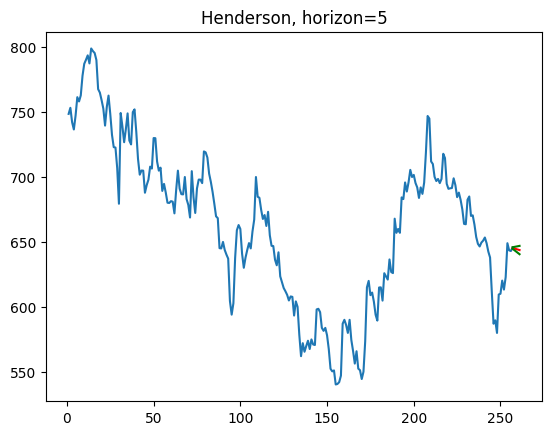

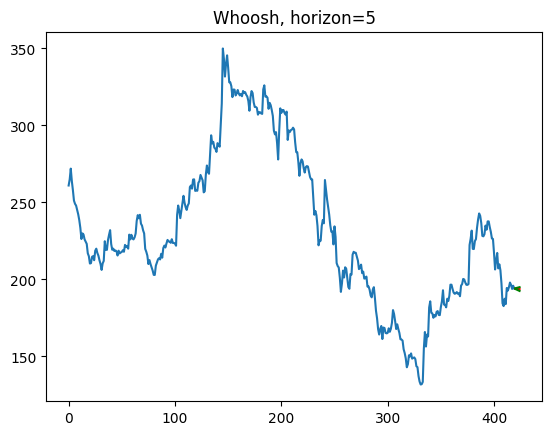

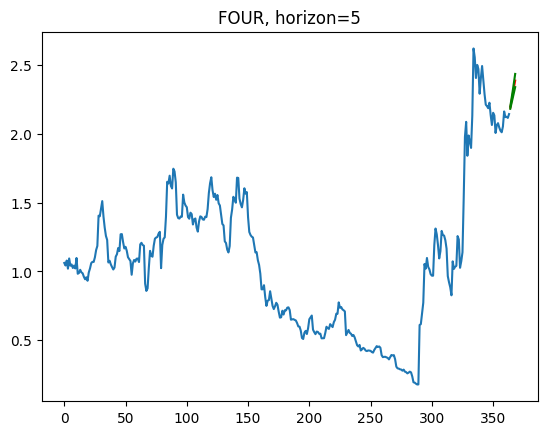

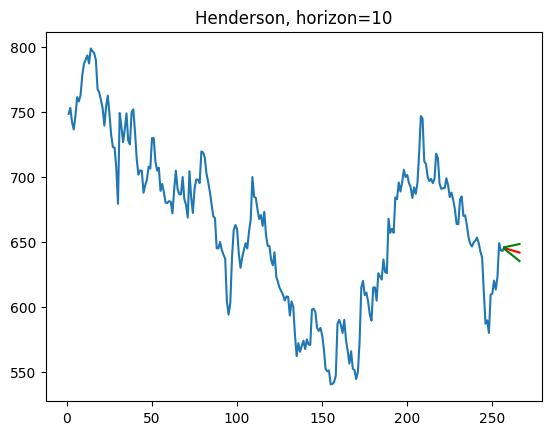

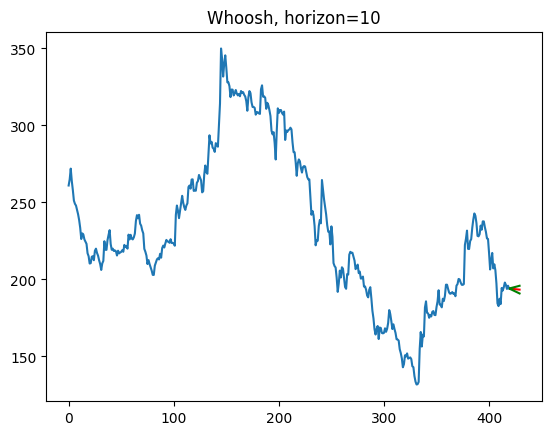

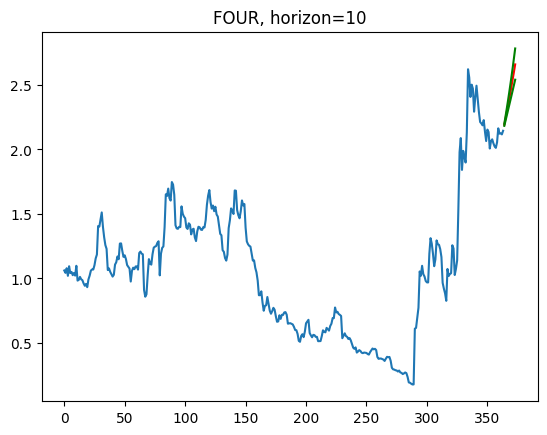

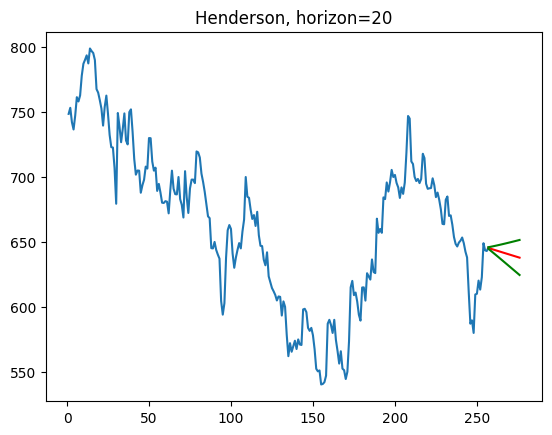

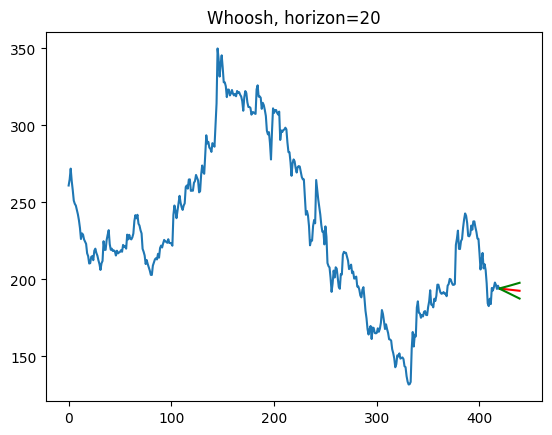

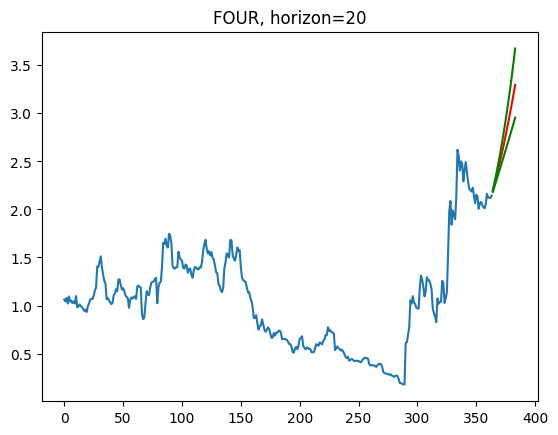

In [10]:
for horizon in (5, 10, 20):
    for name, pred in predictions[horizon].items():
        ln = len(origs[name])
        plt.plot(origs[name])
        plt.plot(list(range(ln, ln+horizon)), pred[0, :], color="red")
        plt.plot(list(range(ln, ln+horizon)), pred[1, :], color="green")
        plt.plot(list(range(ln, ln+horizon)), pred[2, :], color="green")
        plt.title(f"{name}, horizon={horizon}")
        plt.show()